In [1]:
!which python

/home/mlongar/miniconda/envs/MG/bin/python


In [2]:
import tensorflow as tf

In [1]:
import tensorflow as tf
from os import path
import sys
tf.logging.set_verbosity(tf.logging.ERROR)
sys.path.append(path.join(".."))

In [2]:
%%html
<style>
table {
    float: left;
}

.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>

In this example, we used two datasets of pancreatic cells. For gene markers, we used the Panglao Cell Type Marker database.

We used the Baron (2016) dataset for training the neural network (NN) because it has more cells and classes, and we used the Xin (2016) dataset for testing purposes because all of its classes are present in the Baron dataset.

In [3]:
EPOCHS = 100

In [6]:
%load_ext autoreload
%autoreload 2

import saly
import saly.backend as S
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


SPECIES = 'Human'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
#DATA_PATH = '/Users/MarkDavidLongar/Documents/Coding/MachineLearning/Data/'
#DATA_PATH = 'D:/Data/SingleCellGeneExpression/'
DATASET_BARON_PATH = DATA_PATH + 'baron_2016h.h5ad' 
DATASET_XIN_PATH = DATA_PATH + 'xin_2016.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [7]:
baron_data = saly.load_h5ad(DATASET_BARON_PATH)
xin_data = saly.load_h5ad(DATASET_XIN_PATH)

### Baron

In [8]:
print(baron_data.shape)
baron_data.obs['labels'].unique()

(8569, 20125)


[Acinar cells, Beta cells, Delta cells, PaSC, Ductal cells, Alpha cells, Other, PP cells, Endothelial cell]
Categories (9, object): [Acinar cells, Beta cells, Delta cells, PaSC, ..., Alpha cells, Other, PP cells, Endothelial cell]

Baron has 8569 cells and 20125 genes.

The cells are classified into 9 classes: Acinar cells, Alpha cells, Beta cells, Delta cells, Ductal cells, Endothelial cells, ***Other***, PaSC (i.e. Pancreatic stellate cells) and PP cells (i.e. Gamma cells).

### Xin

In [9]:
print(xin_data.shape)
xin_data.obs['labels'].unique()

(1492, 39851)


[Beta cells, Alpha cells, Delta cells, PP cells]
Categories (4, object): [Beta cells, Alpha cells, Delta cells, PP cells]

Xin has 1492 cells and 39851 genes.

The cells are classified into 4 classes: Alpha cells, Beta cells, Delta cells and PP cells (i.e. Gamma cells).

# Drop rows

We removed every cell classified as 'Other' from the Baron dataset.

In [10]:
baron_data = saly.drop_rows(baron_data, ['Other'])

Dropped 118 cell(s). New shape: (8451, 20125)


This removed 118 cells from Baron, leaving us with 8451 left.

# Load marker genes

We make sure to only load the Human marker genes.

In [11]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)

#### Get the markers and only keep those found in both datasets

In [12]:
markers = saly.get_mutual_markers([baron_data, xin_data], markers_db)

We do this because we want to train the network only on the marker genes found in both datasets, and drop the rest.

In [ ]:
print(len(S.get_used_markers(baron_data.var_names, markers_db)), len(S.get_used_markers(xin_data.var_names, markers_db)))
print(len(markers))

Baron has 7616 markers, and Xin has 7608.

We used only those found in both datasets (7543).

*Note that in this context* ***Marker ≠ Marker Gene*** *because multiple cell types (i.e. markers) can have the same marker gene and so in this context, the number 7545 means 7545 connections in the partially-connected Marker Layer between the cell types and the genes.*

### Make sure every class is in the marker layer

Because some cell types are differently labelled in the marker database, we created a dictionary of aliases.

We also make sure to print out any label that cannot be found in either the list of markers or in the dictionary of aliases.

In [14]:
marker_aliases = {'PaSC' : 'Pancreatic stellate cells',
                  'PP cells' : 'Gamma (PP) cells',
                  'Endothelial cell' : 'Endothelial cells'}

saly.check_labels([baron_data, xin_data], markers, marker_aliases)

# Drop unused genes

We used only the genes found in both datasets and the marker gene database, and therefore, we will connect with the partially-connected marker layer.

In [15]:
baron_data = saly.drop_unused_genes(baron_data, markers)
xin_data = saly.drop_unused_genes(xin_data, markers)

Dropped 15952 gene(s). New shape: (8451, 4173)
Dropped 35678 gene(s). New shape: (1492, 4173)


After this operation we are left with 4173 genes.

#### Make sure the data sets' shapes match

In [16]:
saly.check_shape([baron_data, xin_data])

# Data transformation

#### Preprocess the data

We shuffle, log10 transform and split the data into 70%, 15%, 15% splits.

In [17]:
train_data, validation_data, test_data = saly.preprocess_data(baron_data, train=0.7, validation=0.15, test=0.15,
                                                              norm='log10')

Trying to set attribute `.X` of view, making a copy.


#### Log10 transform the Xin data, too

In [18]:
xin_data.X = S.log10(xin_data.X)

Trying to set attribute `.X` of view, making a copy.


# Building the model

For the model we define a partially-connected Marker Layer.

The layer has a node for each cell type whose genes are present in both data sets.
In this case, there are 179 nodes in the marker layer representing 179 cell types. 

We only connect nodes (i.e. the cell types) in the marker layer to their marker genes at the input.

We constructed the partially connected marker layer by taking a dense layer and adding a connection mask (a binary matrix) to it, which we multiply with the output matrix.

We trained the network for 100 epochs.

For training the network we used two losses:

    1) A loss that measured the network's classification accuracy (cross entropy)
    
    2) A loss that measured the network's reconstruction accuracy (mean square error)
           During training we scaled the MSE score 100x to compensate for the losses' different scales

### The Architecture
|Layer|Nodes|
|-----|------|
|Input|4173 (genes)|
|Markers|179 (cell types)|
|Dense layer|100|
|**Bottleneck**|**25**|
|Dense layer|100|
|*Dropout*|*10%*|
|Output|4173 (genes)|

#### Create the model

In [48]:
model, marker_model, encoder_model = saly.build_model(baron_data, markers, supervised=False);

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 4173)              0         
_________________________________________________________________
partial_7 (Partial)          (None, 853)               3560422   
_________________________________________________________________
cell_activations (Partial)   (None, 179)               152866    
_________________________________________________________________
dense_13 (Dense)             (None, 100)               18000     
_________________________________________________________________
Bottleneck (Dense)           (None, 25)                2525      
_________________________________________________________________
dense_14 (Dense)             (None, 100)               2600      
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
__________

# Train the model

In [50]:
history = saly.train_model(model, train_data, markers, marker_aliases,
                           EPOCHS, validation_data=validation_data, verbose=1);

Train on 5915 samples, validate on 1267 samples
Epoch 1/100
5915/5915 [==============================] - 3s 562us/step - loss: 12.5002 - cell_activations_loss: 0.0000e+00 - output_loss: 0.0125 - cell_activations_marker_prediction_metric: 0.1014 - val_loss: 3.1039 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 0.0031 - val_cell_activations_marker_prediction_metric: 0.1026
Epoch 2/100
5915/5915 [==============================] - 1s 178us/step - loss: 3.0711 - cell_activations_loss: 0.0000e+00 - output_loss: 0.0031 - cell_activations_marker_prediction_metric: 0.1016 - val_loss: 3.0614 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 0.0031 - val_cell_activations_marker_prediction_metric: 0.1018
Epoch 3/100
5915/5915 [==============================] - 1s 170us/step - loss: 3.0365 - cell_activations_loss: 0.0000e+00 - output_loss: 0.0030 - cell_activations_marker_prediction_metric: 0.1016 - val_loss: 3.0331 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 0.0

5915/5915 [==============================] - 1s 161us/step - loss: 2.4825 - cell_activations_loss: 0.0000e+00 - output_loss: 0.0025 - cell_activations_marker_prediction_metric: 0.1035 - val_loss: 2.5315 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 0.0025 - val_cell_activations_marker_prediction_metric: 0.1034
Epoch 50/100
5915/5915 [==============================] - 1s 160us/step - loss: 2.4804 - cell_activations_loss: 0.0000e+00 - output_loss: 0.0025 - cell_activations_marker_prediction_metric: 0.1035 - val_loss: 2.5289 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 0.0025 - val_cell_activations_marker_prediction_metric: 0.1042
Epoch 51/100
5915/5915 [==============================] - 1s 163us/step - loss: 2.4788 - cell_activations_loss: 0.0000e+00 - output_loss: 0.0025 - cell_activations_marker_prediction_metric: 0.1036 - val_loss: 2.5289 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 0.0025 - val_cell_activations_marker_prediction_metric: 0.1042

5915/5915 [==============================] - 1s 167us/step - loss: 2.4211 - cell_activations_loss: 0.0000e+00 - output_loss: 0.0024 - cell_activations_marker_prediction_metric: 0.1048 - val_loss: 2.4947 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 0.0025 - val_cell_activations_marker_prediction_metric: 0.1050
Epoch 98/100
5915/5915 [==============================] - 1s 165us/step - loss: 2.4195 - cell_activations_loss: 0.0000e+00 - output_loss: 0.0024 - cell_activations_marker_prediction_metric: 0.1048 - val_loss: 2.4944 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 0.0025 - val_cell_activations_marker_prediction_metric: 0.1050
Epoch 99/100
5915/5915 [==============================] - 1s 172us/step - loss: 2.4174 - cell_activations_loss: 0.0000e+00 - output_loss: 0.0024 - cell_activations_marker_prediction_metric: 0.1050 - val_loss: 2.4926 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 0.0025 - val_cell_activations_marker_prediction_metric: 0.1050

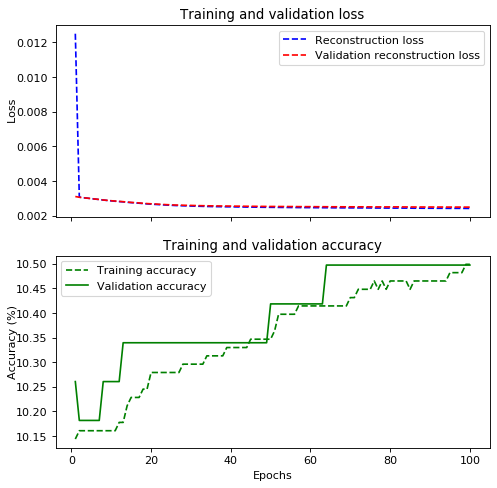

Test reconstruction loss: 0.00248347
Test prediction accuracy: 10.923 %


In [51]:
saly.plot_model_history(history)
saly.test_model(model, test_data, markers, marker_aliases);

# Data analysis

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE()
colours = S.load_label_colours('Data/baron_xin_label_colours.pickle') 

## Baron predictions

In [53]:
baron_cell_activations = marker_model.predict(test_data.X)
baron_bottleneck_activations = encoder_model.predict(test_data.X)

In [54]:
saly.get_average_auc(test_data.obs['labels'], baron_cell_activations, markers, marker_aliases)

Average ROC AUC: 0.525


/home/mlongar/miniconda/envs/MG/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


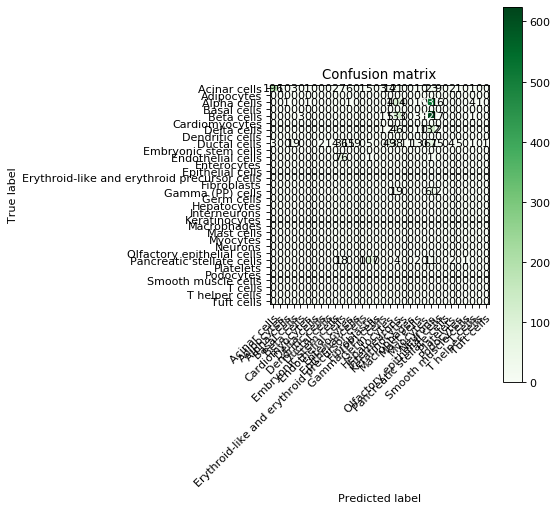

In [55]:
saly.draw_confusion_matrix(test_data.obs['labels'], baron_cell_activations, markers, marker_aliases)

The graph below shows the mean cell type activations. Note that only one cell type explicitly activates.

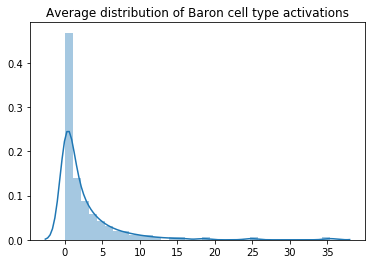

In [56]:
saly.plot_activation_distribution(baron_cell_activations, markers,
                                  title='Average distribution of Baron cell type activations')

In [57]:
saly.get_results(test_data.obs['labels'], baron_cell_activations, markers, marker_aliases)

Correct predictions: 277 out of 2536 (10.92%)


The network correctly classifies 98% of test data from the training database.

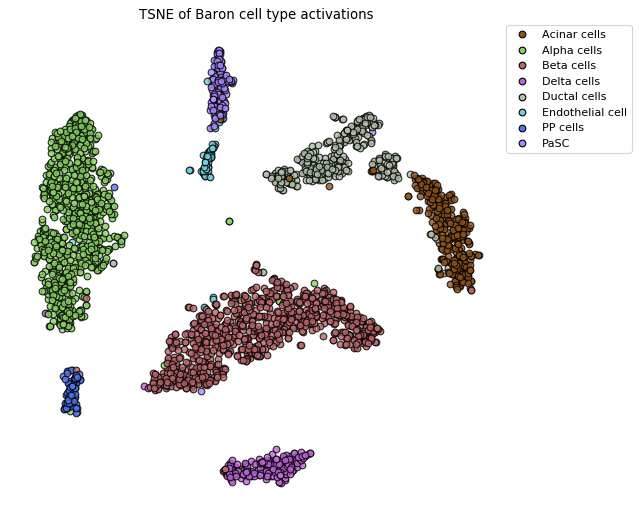

In [37]:
saly.draw_embedding(baron_cell_activations, test_data.obs['labels'], tsne, colours=colours, alpha=0.8,
                    graph_title='TSNE of Baron cell type activations');

## Xin predictions

In [58]:
xin_cell_activations = marker_model.predict(xin_data.X)

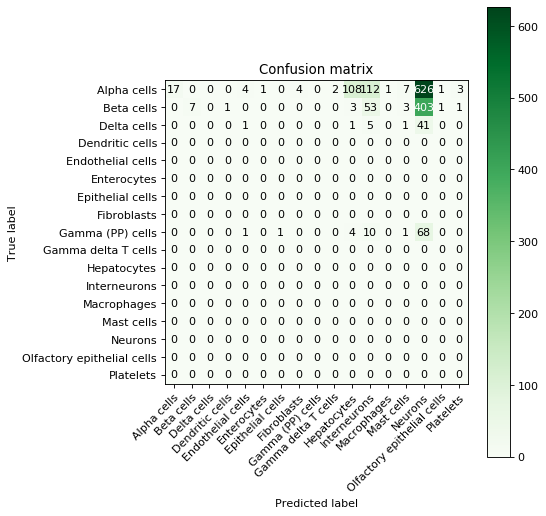

In [59]:
saly.draw_confusion_matrix(xin_data.obs['labels'], xin_cell_activations, markers, marker_aliases)

In [60]:
saly.get_average_auc(xin_data.obs['labels'], xin_cell_activations, markers, marker_aliases)

Average ROC AUC: 0.5


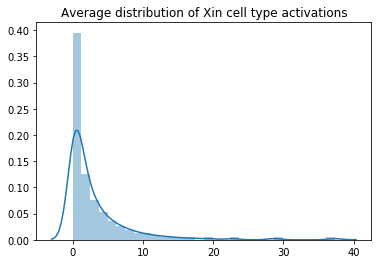

In [61]:
saly.plot_activation_distribution(xin_cell_activations, markers,
                                  title='Average distribution of Xin cell type activations')

In [62]:
saly.get_results(xin_data.obs['labels'], xin_cell_activations, markers, marker_aliases)

Correct predictions: 24 out of 1492 (1.61%)


The network correctly classifies almost 100% of data from a completely new data set.

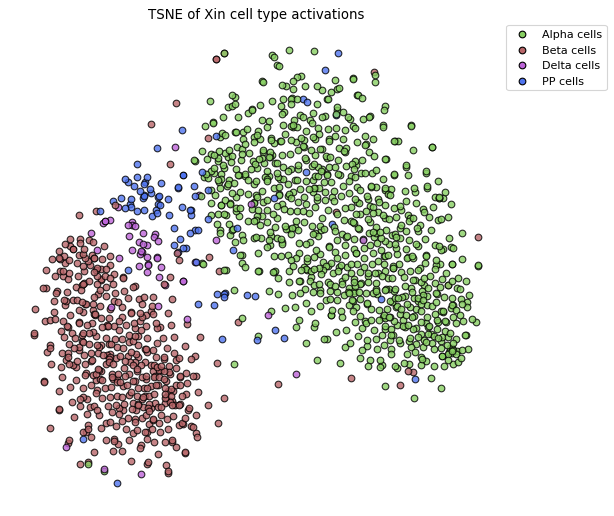

In [64]:
saly.draw_embedding(xin_cell_activations, xin_data.obs['labels'], tsne, colours=colours, alpha=0.8,
                    graph_title='TSNE of Xin cell type activations');

# Reconstruction

Here we took the Xin data set and run them through the autoencoder.

Then we took the autoencoder's output (i.e. the reconstructed data) and ran that data through the autoencoder again, this time looking at the Marker layer's cell type activations.

The cell type activations of the reconstructed data give similar, sometimes worse, but almost never better results.

In [34]:
reconstruction = model.predict(xin_data)[1]
reconstruction = pd.DataFrame(reconstruction, columns=xin_data.columns)
reconstructed_cell_activations = marker_model.predict(reconstruction)
reconstructed_bottleneck_activations = encoder_model.predict(reconstruction)

In [46]:
saly.get_average_auc(xin_labels, reconstructed_cell_activations, markers, marker_aliases)

Average ROC AUC: 0.99


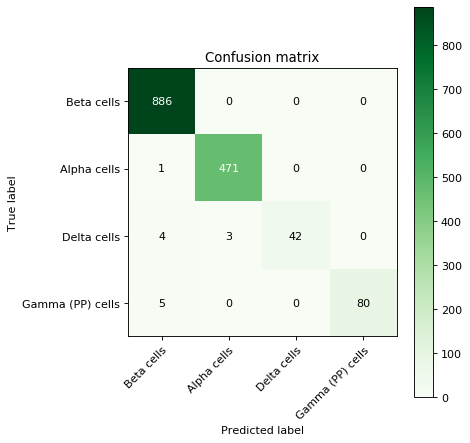

In [36]:
saly.draw_confusion_matrix(xin_labels, reconstructed_cell_activations, markers, marker_aliases)

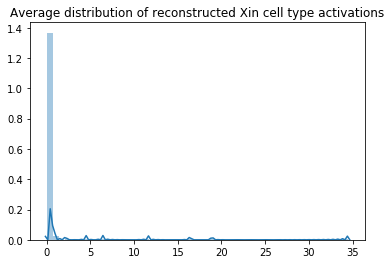

In [37]:
saly.plot_activation_distribution(reconstructed_cell_activations, markers,
                                  title='Average distribution of reconstructed Xin cell type activations')

In [38]:
saly.get_results(xin_labels, reconstructed_cell_activations, markers, marker_aliases)

Correct predictions: 1479 out of 1492 (99.13%)


The network correctly classifies almost 99% of reconstructed Xin data, similar to the original data.

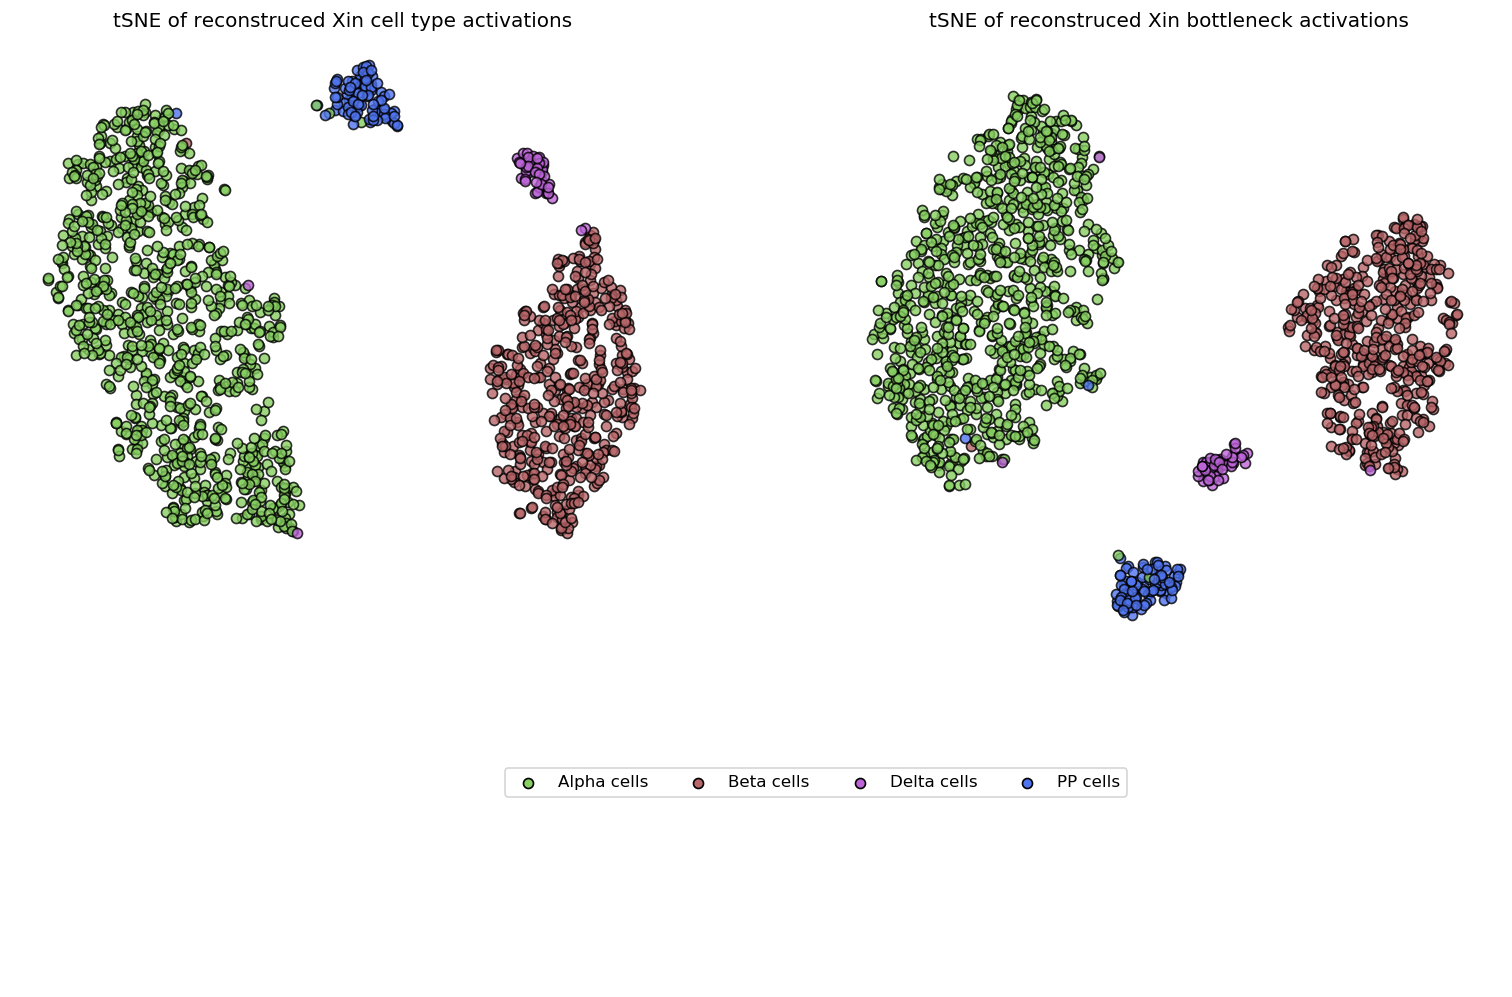

In [39]:
saly.compare_embeddings([reconstructed_cell_activations, xin_labels],
                        [reconstructed_bottleneck_activations, xin_labels],
                        tsne, colours=colours, alpha=0.8,
                        graph_titles=['tSNE of reconstruced Xin cell type activations',
                                      'tSNE of reconstruced Xin bottleneck activations'])

# Combined data

Here we see if our marker activations still have batch effects.

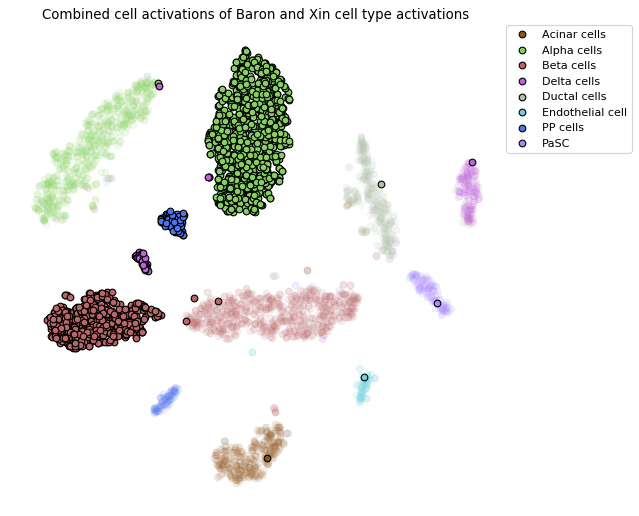

In [40]:
saly.draw_comparison([baron_cell_activations, test_y], [xin_cell_activations, xin_labels] ,tsne, colours=colours,
                     graph_title='Combined cell activations of Baron and Xin cell type activations')

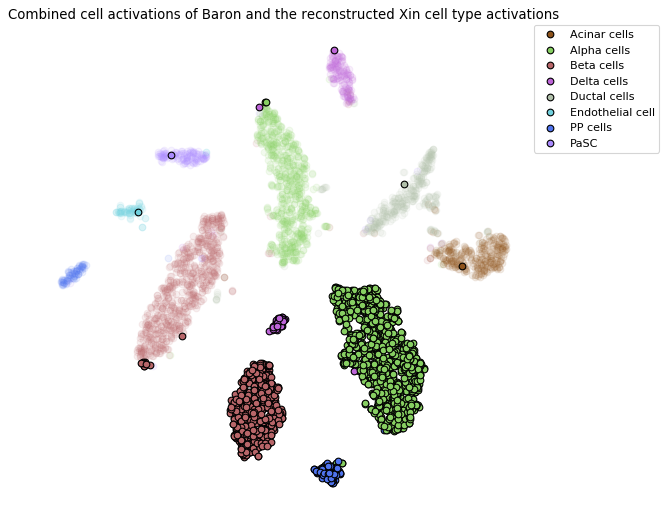

In [41]:
saly.draw_comparison([baron_cell_activations, test_y], [reconstructed_cell_activations, xin_labels], tsne,
                     colours=colours, 
                     graph_title='Combined cell activations of Baron and the reconstructed Xin cell type activations')

# Top 3 activations

We also tried to see if taking only the top 3 cell activations would help us remedy the batch effect.

In [42]:
baron_top_3 = saly.get_top_activations(3, baron_cell_activations)
xin_top_3 = saly.get_top_activations(3, xin_cell_activations)
reconstructed_top_3 = saly.get_top_activations(3, reconstructed_cell_activations)

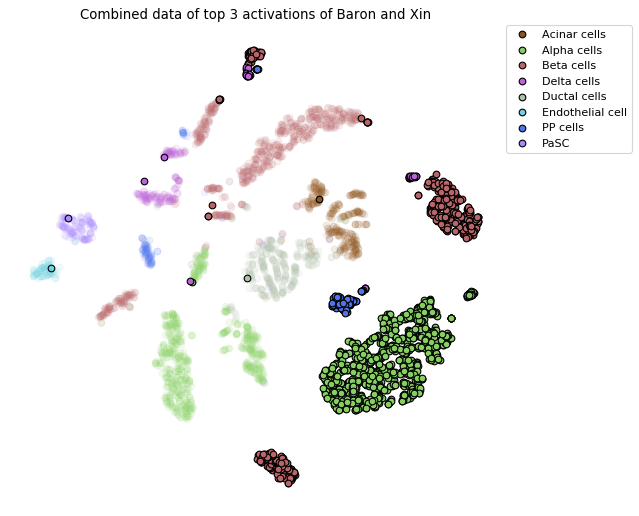

In [43]:
saly.draw_comparison([baron_top_3, test_y], [xin_top_3, xin_labels], tsne, colours=colours,
                     graph_title='Combined data of top 3 activations of Baron and Xin')

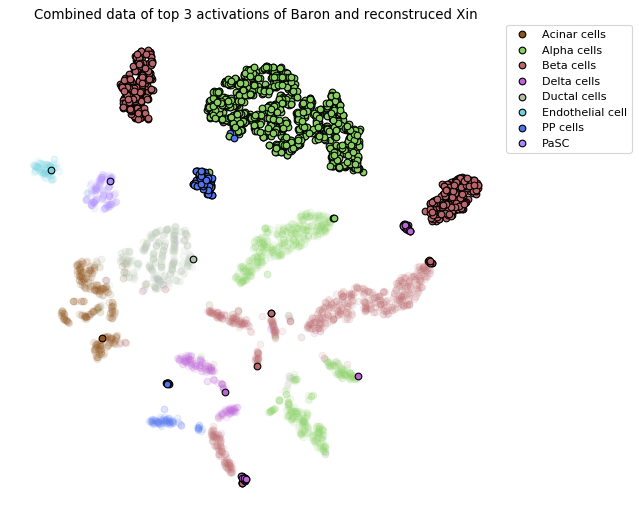

In [44]:
saly.draw_comparison([baron_top_3, test_y], [reconstructed_top_3, xin_labels], tsne, colours=colours,
                     graph_title='Combined data of top 3 activations of Baron and reconstruced Xin')